# Confidence Levels of Google Cloud Vision API's transcriptions
## `merged_df` csv has the API transcriptions, human transcriptions, calculated error between the two and the confidence level for each submission
### `confidence_flag.py` file in the app is created from this notebook

### Build csv with both api and human transcriptions

In [103]:
# Imports
import pandas as pd
import pylcs
import os.path
import seaborn as sns
from scipy import stats

In [2]:
# Bring in the human transcribed and Google API transcribed csv's
human = pd.read_csv('human_metrics.csv')
api = pd.read_csv('api_metrics.csv')

In [3]:
# Keep only the transcriptions and the story_ID
# Rename to specify api transcripption or human transcription

human = human[['story_id', 'transcription']].rename(columns={'transcription': 'human transcription'})
api = api[['story_id', 'transcription']].rename(columns={'transcription': 'api transcription'})

In [4]:
# There were 3 story_id's that were not correct
# That also made the datatype of the entire column an object - need to convert to int to merge

human['story_id'][55] = 3215
human['story_id'][64] = 3213
human['story_id'][104] = 5240

human['story_id'] = human['story_id'].astype(str).astype(int)

In [5]:
# Merge two tables on story_id
merged_df = pd.merge(human, api, on= 'story_id')
merged_df.head()

,story_id,human transcription,api transcription
0,3132,Page 1 Once there was a little cheatah and the...,Page. I 3132 Once there was a little cheatah a...
1,3104,The pony that didn't know. Once there was a po...,"D she was very, a berenang The pony that didn'..."
2,3103,Rainbow the Unica Once there was a unicorn nam...,Rainbow the Unica unicom named some een Pearl ...
3,3117,gumdrop land 1 gumdrop land is a place were gu...,O gum drop land gumdrop. land is prace Were gu...
4,3102,The secret fifth grade I am Amelia I am starti...,The secret fifth grade E am Anella I am starti...


### Calculate error and add to df

In [6]:
def calc_error(t1, t2):
    """Takes in two different transcriptions of a story, returns the error score"""

    # cut out the spaces in both -- the human transcripts use spaces visually
    # this may also eliminate real space errors but I think it's better
    t1 = t1.replace(" ", "")
    t2 = t2.replace(" ", "")

    # transcripts may differ in exact length
    avg_length = (len(t1) + len(t2)) / 2

    # result: average number of single-character errors per character
    return pylcs.levenshtein_distance(t1, t2) / avg_length

In [7]:
# Add an error column to have index locations to index to
merged_df['error'] = 0.0

In [8]:
# Calculate the error between the two transcriptions - populate error column
for i in range(merged_df.shape[0]):
    merged_df.loc[i, 'error'] = calc_error(merged_df.loc[i, 'human transcription'], merged_df.loc[i, 'api transcription'])

merged_df.head(10)

,story_id,human transcription,api transcription,error
0,3132,Page 1 Once there was a little cheatah and the...,Page. I 3132 Once there was a little cheatah a...,0.055957
1,3104,The pony that didn't know. Once there was a po...,"D she was very, a berenang The pony that didn'...",0.364450
2,3103,Rainbow the Unica Once there was a unicorn nam...,Rainbow the Unica unicom named some een Pearl ...,0.383740
3,3117,gumdrop land 1 gumdrop land is a place were gu...,O gum drop land gumdrop. land is prace Were gu...,0.270862
4,3102,The secret fifth grade I am Amelia I am starti...,The secret fifth grade E am Anella I am starti...,0.136770
5,3105,"My alarm clock went off. I got out of bed, put...",brushed my My darm dock went off. I got out of...,0.145624
6,3129,"""found it"" said Katrina, a villan who roamed a...","found it"" said Katrina, a villan who roamed ar...",0.064485
7,3116,1 So once there was a turtle name Cacti. He li...,so a vermewhere log and 1 once there was turtl...,0.169014
8,3111,Lia Hi my name is Lia Clark. My twin sister's ...,"Hi my name is lia Clark, My twin sister's name...",0.025674
9,3118,"1 "" This is my jungle. I had it first and you ...","you this you you want 1 ""This is my jungle. I ...",0.112222


### Calculate confidence and add to df
- Final method we used; calculate the confidence of each character in the entire submission, then return the average confidence
- `confidence_flag.py` in the app uses the `image_confidence` method and calculates the confidence level at the character level and raises a flag is the confidence for a page is lower than 0.85.

In [195]:
def image_confidence(image_path):
    '''
    Detects text in images and calculates the confidence level for each
    character. Returns a True boolean if the overall confidence for the
    page is less than 0.85. Otherwise, returns False

        Input: Path to file where image is stored
            One image per call: run function on each image in a submission
        Output: Boolean; True if confidence level for page is less than 0.85
                False if confidence is 0.85 or greater
    '''
    # Imports needed specificially for this function
    from google.cloud import vision
    import io
    from google.oauth2 import service_account

    # If image_path is local
    with io.open(image_path, 'rb') as image_file:
        content = image_file.read()
    image = vision.types.Image(content=content)

    # # If image_path is a uri
    # image = vision.types.Image()
    # image.source.image_uri = uri

    # Set language to english only
    language = vision.types.ImageContext(language_hints=['en-t-i0-handwrit'])

    # Connect to Google API client
    creds = service_account.Credentials.from_service_account_file('/Users/stevenchase/Desktop/Steven/Computer_Science/Lambda/labs/story_sqaud/Story Squad-6122da7459cf.json')
    client = vision.ImageAnnotatorClient(credentials=creds)
    response = client.document_text_detection(image=image, image_context=language)

    # List of confidence levels of each word
    symbol_confidences = []

    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        symbol_confidences.append(symbol.confidence)
                        
    # If there is no text on the page, needs to return a list
    if len(symbol_confidences) == 0:
        return [-1]
    else:
        # Return list of all of the confidences for each character
        return symbol_confidences

In [196]:
def multi_page(directory):
    '''
    Function calls image_confidence function for each page in a single submission
        Input: file path containing images of user's written stories
        Output: Float; Confidence in the transcription of the entire submission
    '''

    paths = []

    for item in os.listdir(directory):
        if item[-3:] == 'jpg':
            path = os.path.join(directory, item)
            paths.append(path)

    submission_confidence = []

    for image_path in paths:
        submission_confidence.extend(image_confidence(image_path))
    
    # Drop any '-1' (meaning no text detected) responses from confidence function
    submission_confidence = [x for x in submission_confidence if x != -1]

    # Check to make sure that submission_confidence isn't empty
    if len(submission_confidence) == 0:
        return 0
    else:
        confidence_level = sum(submission_confidence) / len(submission_confidence)
        return confidence_level

In [188]:
# Add a confidence column to be able to refer to the index
merged_df['confidence'] = 0.0

In [189]:
merged_df

,story_id,human transcription,api transcription,error,confidence
0,3132,Page 1 Once there was a little cheatah and the...,Page. I 3132 Once there was a little cheatah a...,0.055957,0.0
1,3104,The pony that didn't know. Once there was a po...,"D she was very, a berenang The pony that didn'...",0.364450,0.0
2,3103,Rainbow the Unica Once there was a unicorn nam...,Rainbow the Unica unicom named some een Pearl ...,0.383740,0.0
3,3117,gumdrop land 1 gumdrop land is a place were gu...,O gum drop land gumdrop. land is prace Were gu...,0.270862,0.0
4,3102,The secret fifth grade I am Amelia I am starti...,The secret fifth grade E am Anella I am starti...,0.136770,0.0
...,...,...,...,...,...
162,5132,"One day, in the middle of August, there was a ...","up One day, in the middle of August, there was...",0.089368,0.0
163,5103,"=> ""Hey[]"" exclaimed Tommy, ""thats my phone, w...","mom the S103 Indent Heytilen exclaimed Tommy, ...",0.251528,0.0
164,5104,One day a kid named Steven was at school he ha...,he from la so as -5164 No Hone Work One day a ...,0.598857,0.0
165,5105,[]The wind was howeling against my window. [] ...,S AT was 2 2 The wind howeling against my wind...,0.302930,0.0


In [190]:
# Root directory
root_directory = os.path.join('/Users/stevenchase/Desktop/Steven/Computer_Science/Lambda/labs/story_sqaud', 'Stories Dataset', "Transcribed Stories")

In [197]:
# Calculate the confidence for each transcription
for i in range(merged_df.shape[0]):
    # Build the directory path based off of the story_id
    directory = os.path.join(root_directory, str(merged_df['story_id'][i])[:2] + '--', str(merged_df['story_id'][i]))

    # Populate confidence column with call of multi_page function on each row
    merged_df.loc[i, 'confidence'] = multi_page(directory)

merged_df.head()

,story_id,human transcription,api transcription,error,confidence
0,3132,Page 1 Once there was a little cheatah and the...,Page. I 3132 Once there was a little cheatah a...,0.055957,0.959946
1,3104,The pony that didn't know. Once there was a po...,"D she was very, a berenang The pony that didn'...",0.364450,0.894102
2,3103,Rainbow the Unica Once there was a unicorn nam...,Rainbow the Unica unicom named some een Pearl ...,0.383740,0.946982
3,3117,gumdrop land 1 gumdrop land is a place were gu...,O gum drop land gumdrop. land is prace Were gu...,0.270862,0.895751
4,3102,The secret fifth grade I am Amelia I am starti...,The secret fifth grade E am Anella I am starti...,0.136770,0.916551


In [76]:
merged_df.to_csv('error_confidence_metrics.csv')

### Explore confidence metrics and relationship with calculated error
- First Correlation metric: -0.25
- Correlation after dropping the missing images: -0.46

Final method of getting confidence level (by character for the entire submission)
- First Correlation metric: -0.29
- After dropping the missing images: -0.49

In [80]:
# Explore distribution of confidence 
merged_df['confidence'].describe()

count    167.000000
mean       0.905906
std        0.044304
min        0.728981
25%        0.895665
50%        0.916216
75%        0.935226
max        0.961698
Name: confidence, dtype: float64

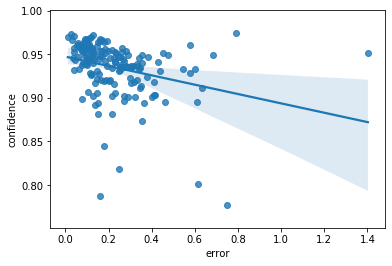

In [198]:
# Scatter plot to compare relationship between error and confidence level
sns.regplot(x="error", y="confidence", data=merged_df);


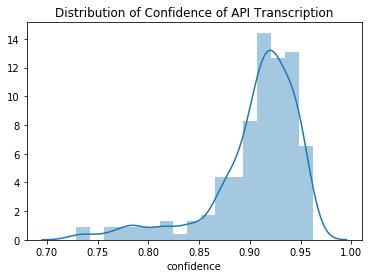

In [101]:
ax = sns.distplot(merged_df['confidence'])
plt.title("Distribution of Confidence of API Transcription")
plt.show()

In [199]:
merged_df.corr()

,story_id,error,confidence
story_id,1.000000,-0.050345,0.023507
error,-0.050345,1.000000,-0.299523
confidence,0.023507,-0.299523,1.000000


### Explore outliers and reasons for bad correlation

In [200]:
# Copy of df to manipulate

confidence_df = merged_df[['story_id', 'error', 'confidence']]
confidence_df.head()

,story_id,error,confidence
0,3132,0.055957,0.959946
1,3104,0.364450,0.894102
2,3103,0.383740,0.946982
3,3117,0.270862,0.895751
4,3102,0.136770,0.916551


### Some stories had missing pages for the human transcription which resulted in inaccurate error calculations. Those were dropped below.
### Additionally, we found the following human transcription errors. We believe this was a small enough sample size that it didn't affect the correlation too much. But they are important to keep in mind so I will note them here for future iterations.
- Story 5202: There is text added to a sentence by the child using a ^. It is placed out of order. There are also a few '[]' throughout the transcription. One is for something that is crossed out. The others are smudges on the paper. Typo 'Jlack' instead of 'Jack' on the second page.
- Story 3109: Text added by ^ is out of place. Includes some text from an illustration. [] brackets where words are crossd out. 
- Story 3114: Carrot out of place

The convention seems to be the text associated with a carrot (^) where the student is adding to a sentence is out of order. Words that are crossed out are indicated by []. Sometimes text in illustrations are included but most times they are not. The human transcriptions errors do not seem too drastic to affect the calculated errors. 


In [201]:
# Drop stories that had known human error in the the transcriptions - missing pages
to_drop = [3213, 3215, 3240, 5104, 5109, 5262]

In [202]:
# Drop outliers to see the relationship better

for i in range(confidence_df.shape[0]):
    if confidence_df['story_id'][i] in to_drop:
        confidence_df = confidence_df.drop(i)
        print(i)

55
64
66
80
145
164


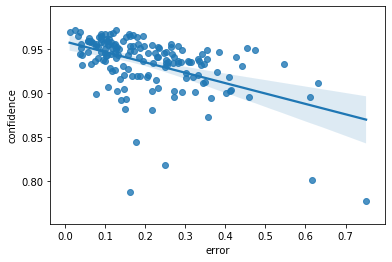

In [203]:
sns.regplot(x="error", y="confidence", data=confidence_df);

In [204]:
confidence_df.corr()

,story_id,error,confidence
story_id,1.000000,-0.028041,0.030630
error,-0.028041,1.000000,-0.492487
confidence,0.030630,-0.492487,1.000000


### Explore values that have a high confidence but also have a high error metric

In [205]:
# Create sub_df to explore the worst correlation data points
condition_1 = confidence_df['error'] >= 0.4
condition_2 = confidence_df['confidence'] >= 0.85

outlier_df = confidence_df[condition_1 & condition_2]
outlier_df

,story_id,error,confidence
16,3128,0.610937,0.895146
33,3216,0.454545,0.951636
34,3229,0.408889,0.918442
60,3246,0.427553,0.940928
62,3222,0.474832,0.949171
93,5208,0.415114,0.903336
99,5241,0.411483,0.902887
141,5122,0.459770,0.895210
144,5114,0.631939,0.911629
158,5119,0.546148,0.932757


Notes on the top 12 worst correlations:

3128: Handwriting seemed fine. API transcription had a lot of words out of order which is what lead to the higher error metric. Could have been because some of it was faint handwriting.

3216: Handwriting was fine, it was written front and back so you could faitly make out some of the words written on the back. Wonder if that threw google off. Might be able to clean that up

3229: Transcription wasn't actually that bad. But it was a very short piece of writing so the error metric was heavily influenced by a few mistakes.

3246: Some light writing

3222: Faint handwriting

5208: Page is crowded, the words are all pushed together and the letters are tall on the lines

5241: IDK

5122: Crossed out the first paragraph, google still tried to transcribe that

5114: Some erase marks in few paragraphs, other than that good handwriting

5119: IDK

5110: Messy, different colors, crossed out material

5102: Crossed out words

In [216]:
# Low confidence subset to explore any commonalities
low_confidence_df = confidence_df[confidence_df['confidence'] < 0.85]
low_confidence_df

,story_id,error,confidence
24,3112,0.177743,0.844136
27,3124,0.751310,0.777286
86,5264,0.616956,0.801282
116,5202,0.248390,0.818169
143,5113,0.161404,0.787450


Notes on confidence below 0.85

3112: IDK

3124, 5264, 5202: words pushed together

5113: small writing, words are spaced but letters are crowded

# Experimental work
## Explore different ways of calculating confidence levels, see if that effects the correlation
### Look at the first 25 samples
- confidence by word per page
- confidence by word entire submission at once
- confidence by character entrie submission at once

We ended up getting the best correlation for the first 25 samlpes by retrieving the confidence level of every character across the entire submission before aggregating a total confidence level - will use that method on the entire dataset of stories

In [164]:
# Drop the stories that have missing data
cleaned_df = merged_df.copy()

for i in range(cleaned_df.shape[0]):
    if cleaned_df['story_id'][i] in to_drop:
        cleanded_df = cleaned_df.drop(i)
        print(i)

55
64
66
80
145
164


In [166]:
# Subset of first 25 rows to experiment with
df_25 = cleaned_df[:25]
df_25.shape

(25, 5)

### Confidence by word per page metrics

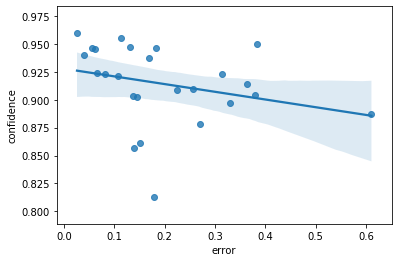

In [174]:
sns.regplot(x="error", y="confidence", data=confidence_df[:25]);

In [176]:
confidence_df[:25].corr()

,story_id,error,confidence
story_id,1.000000,-0.131402,0.151173
error,-0.131402,1.000000,-0.273108
confidence,0.151173,-0.273108,1.000000


### Confidence by character by page

In [169]:
# Function to get submission confidence by character per page
def character_page_confidence(image_path):
    '''
    Detects document features in images and returns overall confidence level of transcribed text
        Input: Path to file where images are stored
        - Assuming 1 image per image_path - run this on each individual image in one submission
        - Code for both local image_path and remote image_path, comment out
            the apporopriate one
        Output: Float. Decimal format of confidence level of the transcription for the page
    '''

    from google.cloud import vision
    import io
    from google.oauth2 import service_account

    # If image_path is local
    with io.open(image_path, 'rb') as image_file:
        content = image_file.read()
    image = vision.types.Image(content=content)

    # # If image_path is a uri
    # image = vision.types.Image()
    # image.source.image_uri = uri

    # Set language to english only
    language = vision.types.ImageContext(language_hints=['en-t-i0-handwrit'])

    # Connect to Google API client
    creds = service_account.Credentials.from_service_account_file('/Users/stevenchase/Desktop/Steven/Computer_Science/Lambda/labs/story_sqaud/Story Squad-6122da7459cf.json')
    client = vision.ImageAnnotatorClient(credentials=creds)
    response = client.document_text_detection(image=image, image_context=language)

    # List of confidence levels of each word
    symbol_confidences = []

    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    # word_confidences.append(word.confidence)
                    for symbol in word.symbols:
                        symbol_confidences.append(symbol.confidence)
    # If there is no text on the page
    if len(symbol_confidences) == 0:
        return None
    else:
        # Calculate and return the overall confidence for the page
        page_confidence = sum(symbol_confidences) / len(symbol_confidences)

        return float(page_confidence)

In [170]:
def character_multi_page(directory):
    '''
    Function calls page_confidence function for each page in a single submission
        Input: file path containing images of user's written stories
        Output: Float; Confidence in the transcription of the entire submission
    '''
    
    paths = []

    for item in os.listdir(directory):
        if item[-3:] == 'jpg':
            path = os.path.join(directory, item)
            paths.append(path)

    submission_confidence = []

    for image_path in paths:
        submission_confidence.append(character_page_confidence(image_path))
    
    # Drop any 'None' responses from confidence function
    submission_confidence = [x for x in submission_confidence if x is not None]

    # Check to make sure that submission_confidence isn't empty
    if submission_confidence == 0:
        return 0
    else:
        confidence_level = sum(submission_confidence) / len(submission_confidence)
        return confidence_level

In [168]:
df_25['confidence'] = 0.0

In [171]:
# Root directory
root_directory = os.path.join('/Users/stevenchase/Desktop/Steven/Computer_Science/Lambda/labs/story_sqaud', 'Stories Dataset', "Transcribed Stories")

In [172]:
# Calculate the confidence for each transcription
for i in range(df_25.shape[0]):
    # Build the directory path based off of the story_id
    directory = os.path.join(root_directory, str(df_25['story_id'][i])[:2] + '--', str(df_25['story_id'][i]))

    # Populate confidence column with call of multi_page function on each row
    df_25.loc[i, 'confidence'] = character_multi_page(directory)

df_25.head()

,story_id,human transcription,api transcription,error,confidence
0,3132,Page 1 Once there was a little cheatah and the...,Page. I 3132 Once there was a little cheatah a...,0.055957,0.958198
1,3104,The pony that didn't know. Once there was a po...,"D she was very, a berenang The pony that didn'...",0.364450,0.917615
2,3103,Rainbow the Unica Once there was a unicorn nam...,Rainbow the Unica unicom named some een Pearl ...,0.383740,0.959991
3,3117,gumdrop land 1 gumdrop land is a place were gu...,O gum drop land gumdrop. land is prace Were gu...,0.270862,0.895751
4,3102,The secret fifth grade I am Amelia I am starti...,The secret fifth grade E am Anella I am starti...,0.136770,0.917641


#### Confidence by character per page metrics

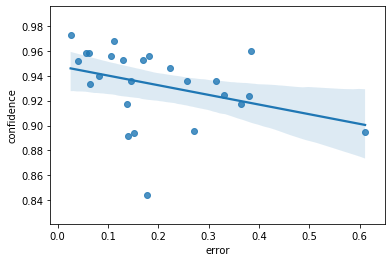

In [173]:
sns.regplot(x="error", y="confidence", data=df_25);

In [175]:
df_25.corr()

,story_id,error,confidence
story_id,1.000000,-0.131402,0.099005
error,-0.131402,1.000000,-0.358734
confidence,0.099005,-0.358734,1.000000


### Confidence by character for the entire submission

In [177]:
# Function to get submission confidence by character per page
def character_submission_confidence(image_path):
    '''
    Detects document features in images and returns overall confidence level of transcribed text
        Input: Path to file where images are stored
        - Assuming 1 image per image_path - run this on each individual image in one submission
        - Code for both local image_path and remote image_path, comment out
            the apporopriate one
        Output: Float. Decimal format of confidence level of the transcription for the page
    '''

    from google.cloud import vision
    import io
    from google.oauth2 import service_account

    # If image_path is local
    with io.open(image_path, 'rb') as image_file:
        content = image_file.read()
    image = vision.types.Image(content=content)

    # # If image_path is a uri
    # image = vision.types.Image()
    # image.source.image_uri = uri

    # Set language to english only
    language = vision.types.ImageContext(language_hints=['en-t-i0-handwrit'])

    # Connect to Google API client
    creds = service_account.Credentials.from_service_account_file('/Users/stevenchase/Desktop/Steven/Computer_Science/Lambda/labs/story_sqaud/Story Squad-6122da7459cf.json')
    client = vision.ImageAnnotatorClient(credentials=creds)
    response = client.document_text_detection(image=image, image_context=language)

    # List of confidence levels of each word
    symbol_confidences = []

    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    # word_confidences.append(word.confidence)
                    for symbol in word.symbols:
                        symbol_confidences.append(symbol.confidence)
    # If there is no text on the page
    if len(symbol_confidences) == 0:
        return None
    else:
        # Return list of all of the confidences for each character
        return symbol_confidences

In [182]:
def character_multi_page_submission(directory):
    '''
    Function calls page_confidence function for each page in a single submission
        Input: file path containing images of user's written stories
        Output: Float; Confidence in the transcription of the entire submission
    '''
    
    paths = []

    for item in os.listdir(directory):
        if item[-3:] == 'jpg':
            path = os.path.join(directory, item)
            paths.append(path)

    submission_confidence = []

    for image_path in paths:
        submission_confidence.extend(character_submission_confidence(image_path))
    
    # Drop any 'None' responses from confidence function
    submission_confidence = [x for x in submission_confidence if x is not None]

    # Check to make sure that submission_confidence isn't empty
    if len(submission_confidence) == 0:
        return 0
    else:
        confidence_level = sum(submission_confidence) / len(submission_confidence)
        return confidence_level

In [181]:
# Create new df
df_25_character_submission = df_25.copy()
df_25_character_submission['confidence'] = 0.0
df_25_character_submission.head()

,story_id,human transcription,api transcription,error,confidence
0,3132,Page 1 Once there was a little cheatah and the...,Page. I 3132 Once there was a little cheatah a...,0.055957,0.0
1,3104,The pony that didn't know. Once there was a po...,"D she was very, a berenang The pony that didn'...",0.364450,0.0
2,3103,Rainbow the Unica Once there was a unicorn nam...,Rainbow the Unica unicom named some een Pearl ...,0.383740,0.0
3,3117,gumdrop land 1 gumdrop land is a place were gu...,O gum drop land gumdrop. land is prace Were gu...,0.270862,0.0
4,3102,The secret fifth grade I am Amelia I am starti...,The secret fifth grade E am Anella I am starti...,0.136770,0.0


In [183]:
# Calculate the confidence for each transcription
for i in range(df_25_character_submission.shape[0]):
    # Build the directory path based off of the story_id
    directory = os.path.join(root_directory, str(df_25_character_submission['story_id'][i])[:2] + '--', str(df_25_character_submission['story_id'][i]))

    # Populate confidence column with call of multi_page function on each row
    df_25_character_submission.loc[i, 'confidence'] = character_multi_page_submission(directory)

df_25_character_submission.head()

,story_id,human transcription,api transcription,error,confidence
0,3132,Page 1 Once there was a little cheatah and the...,Page. I 3132 Once there was a little cheatah a...,0.055957,0.959946
1,3104,The pony that didn't know. Once there was a po...,"D she was very, a berenang The pony that didn'...",0.364450,0.894102
2,3103,Rainbow the Unica Once there was a unicorn nam...,Rainbow the Unica unicom named some een Pearl ...,0.383740,0.946982
3,3117,gumdrop land 1 gumdrop land is a place were gu...,O gum drop land gumdrop. land is prace Were gu...,0.270862,0.895751
4,3102,The secret fifth grade I am Amelia I am starti...,The secret fifth grade E am Anella I am starti...,0.136770,0.916551


#### Confidence by character for entire submission at once

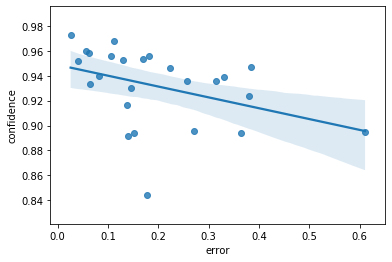

In [184]:
sns.regplot(x="error", y="confidence", data=df_25_character_submission[:25]);

In [185]:
df_25_character_submission.corr()

,story_id,error,confidence
story_id,1.000000,-0.131402,0.151808
error,-0.131402,1.000000,-0.394979
confidence,0.151808,-0.394979,1.000000
